# TODOs
- [X] Metadaten.json zu Python Variablen, in Python Dictionary einspeisen und auslesen (Parkplätze, WiFi) -> Frank
- [X] Map (Slider, Heat Map, Animationen) Visualisierungen -> Frank
- [X] virtual env vorbereiten -> Rich
- [X] projektserver? -> Rich
- [X] Erste Statistiken (Bar Charts, Graphs usw.) Visualisierungen -> Rich
- [ ] Chart Ideen -> Anja
- [ ] Unsere Daten in PowerBI einspeisen, (welche Daten bräuchten wir z.B. für Graph Bubble oder allgemeine Sachen) oder was kostenloses (z.B. CliqSense) -> Anja

# Unsere Quellen zum Visualisierungserfolg:
### Wie Wähle ich die richtige Visualisierung?

https://eazybi.com/blog/data_visualization_and_chart_types/

### Wo finde ich sie in Python?

https://python-graph-gallery.com

# Domänenwissen

* Öffnungszeiten (Theater, Uni)
* Peak Times, Tag
* Ferienzeiten
* Special Events (Demos, Strassensperren)
* Parkplätze kostenlos/bezahlt?
* Sonntag Flohmarkt

# Ideen
* Vergleich mit Wetterdaten
* Verlgeich mit Öffis -> Empfehlungen aussprechen -> z.B. mehr Busse sollen fahren, aber eine U-Bahn kann ausfallen
* Anhand von hauptsächlich Fußgänger könnte man behaupten, wann Vorlesungen auf der TU sind

# Korrelation
* Wie viele fahren rein um bestimmte Uhrzeit rein -> Belegung Parkplätze
* WiFi Nutzung in Zusammenhang mit parkenden Autos?

# Prädiktionen (ML)
* Traffic-/Personenaufkommen zu bestimmten Tageszeiten

# Distribution
* Normalverteilung

# Intervall
* Tageszeiten
* Wochen

# Fragen flow.lab
* Wie wurden Pedestrian Daten aufgenommen?
* Was sind die Daten bei WiFi?
* Gibt es schon Ergebnisse aus Wettbewerb?
* Gibt es neue Daten?
* Erklärung zu Datenset?

## Data für PowerBI

1. Parking:
i. menschlich lesbaren namen geben
ii. TIme in excel format speichern 
    a. wochen (später statistik woche zu woche)
    b. wochentage ( stat wochentag zu denselben ander woche)
    c. tageszeit ( stat pro tag)
    d. Alle Stat über ganze periode, woche, tag
    e. Balkendia mit max-belegung durch tag, woche, ganze periode
    f. haufigkeit der belegung

2. Trafic:
i. Time in excel format speichern
ii. klären was ist overall

3. wifi:
i. no legend - no ststistics

4. pedestrian:
i. Time!
ii. wir können allgemein menschenZahl in bezug zu Zeit analysieren. 
Bsp. 12:00 = 234 am Platz

zu alle : 1 Korellation mit Zeit prüfen
          2 alle Intervalle auf einander legen  - Min Max Median Mittelwert
	  3 Hypotesen: 
		Studis parken
		Flohmarkt parkt
		Stosszeiten ermitteln und gegenbeispiel untersuchen. siehe 2
		Normalverteilt? siehe 2

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import folium
import folium.plugins as plugins
from IPython.display import HTML
import sklearn as sk
import numpy as np
import json

In [3]:
# Hide Code Function

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
The raw code for this IPython notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')

### Erklärungen/Links zu wichtigen Libraries
- Markdown schreiben hier in Jupyter: https://github.com/adam-p/markdown-here/wiki/Markdown-Cheatsheet
- folium für map Visualisierungen: https://github.com/python-visualization/folium

### Daten einlesen
> Erns-Reuter-Platz Datensatz aus http://flow.dai-labor.de

In [4]:
wifi = pd.read_csv('data/wifi.csv')
parking = pd.read_csv('data/parking.csv', delimiter=' ')
# TODO: hier restlichen Datensätze einlesen

### Sinn aus den Daten machen 

In [5]:
# TODO: alle Typen aus der metadata.json in Python Variablen, z.B.:
campus_eb = [52.512388, 13.32360925]
campus_tel = [52.51298775, 13.32029525]
ernst_reuter_platz_center = [52.512611, 13.321856]

# TODO: json daten auslesen
metadata = json.loads(open('data/metadata.json').read())

wifi_latlon = metadata['wifi']['latlon']
pedestrian_latlon = metadata['pedestrian']['latlon']
traffic_latlon = metadata['traffic']['latlon']
parking_latlon = metadata['parking']['latlon']

### Wichtige Libraries
- folium für map Visualisierungen: https://github.com/python-visualization/folium

### Alle WiFi Standorte auf Karte visualisieren

In [6]:
## TODO: take center of ernst-reuter platz as location=POINT
map = folium.Map(location=ernst_reuter_platz_center, zoom_start=17)


for key in wifi_latlon:
    folium.Circle(
        radius=50,
        location=wifi_latlon[key],
        popup=key,
        color='#3186cc',
        fill=True
    ).add_to(map)
    
for key in pedestrian_latlon:
    folium.Marker(
        location=pedestrian_latlon[key],
        popup=key,
        icon=folium.Icon(icon='info-sign')
    ).add_to(map)
    
for key in traffic_latlon:
    folium.Marker(
        location=traffic_latlon[key],
        popup=key,
        icon=folium.Icon(color='red',icon='info-sign')
    ).add_to(map)

for key in parking_latlon:
    folium.Circle(
        radius=2,
        location=parking_latlon[key],
        popup=key,
        color='red',
        fill=True
    ).add_to(map)

map

### Zum Vergleich Originalstandorte:
(TODO: Karte rotieren?)

![Sensor_Locations](images/Sensor_Locations.jpg)

### Parking Data

In [7]:
mean_parking = {}

startTime = float(parking[['Timestamp']].iloc[0])
endTime = float(parking[['Timestamp']].iloc[-1])
timeSpan = endTime - startTime

for key in parking_latlon:
    temp = parking[parking['ParkingSpotID'] == key][['Timestamp','Occupied']]
    occupied = temp.iloc[0]['Occupied'] == 1
    lastTime = startTime
    mean_parking[key] = 0
    for index, row in temp.iterrows():
        if occupied != (row['Occupied'] == 1):
            if occupied:
                mean_parking[key] += row['Timestamp'] - lastTime
            else:
                lastTime = row['Timestamp']
            occupied = row['Occupied'] == 1
    if occupied:
                mean_parking[key] += endTime - lastTime
    mean_parking[key] /= timeSpan
    print(key, ":", mean_parking[key])
            
##for key in parking_latlon:  
##    mean_parking[key] = parking[parking['ParkingSpotID'] == key][['Occupied']].mean()    
## This is the wrong aproach! data points are only created when the Occupied property changes, so the Mean has to be around 50%
## the correct way is to calculate the mean-time the Parking Spot was occupied

##print(mean_parking)


Parking_26 : 0.474575539886
Parking_25 : 0.507358884429
Parking_21 : 0.444967736626
Parking_24 : 0.406502175315
Parking_23 : 0.39272690871
Parking_22 : 0.506686140634
Parking_17 : 0.395940583242
Parking_20 : 0.307926653297
Parking_19 : 0.417169446775
Parking_18 : 0.356526235319
Parking_07 : 0.26688800011
Parking_16 : 0.370566557809
Parking_09 : 0.419378954077
Parking_08 : 0.372094605674
Parking_06 : 0.52936338214
Parking_05 : 0.430512026483
Parking_04 : 0.373508213037
Parking_03 : 0.436688238751
Parking_02 : 0.412716671396
Parking_01 : 0.429373583466
Parking_15 : 0.422317843203
Parking_14 : 0.367553827408
Parking_13 : 0.389885595024
Parking_10 : 0.426487532181
Parking_11 : 0.407449006253
Parking_29 : 0.426950554563
Parking_12 : 0.489680462097
Parking_27 : 0.389874369278
Parking_28 : 0.404095514639
Parking_30 : 0.394625316275
Parking_31 : 0.27065871783
Parking_32 : 0.576981666103


In [8]:
parkplatz_center = [52.513025, 13.319505]
parking_map = folium.Map(location=parkplatz_center, zoom_start=18)

for key in parking_latlon:
    visual = (mean_parking[key] - 0.25) * 2
    folium.Circle(
        radius=1,
        location=parking_latlon[key],
        popup=key,
        color='#%02x%02x%02x' % (int(255 * (1-visual)),int(255 * (1-visual)), int(255 * (1-visual))),
        fill=True
    ).add_to(parking_map)
    
## schwarz = häufig belegt, weiß = weniger häufig belegt
# TODO: Prozente 
parking_map

# Basic Statistics

## Pedestrians

In [9]:
df_pedestrians_original = pd.read_csv('data/pedestrian_counts_tel_a.csv', sep=" ")
print('Total number of entries: \n\n' + str(df_pedestrians_original.count()))
print('\n\nExample Output: ')
df_pedestrians_original.head()

Total number of entries: 

StationIdentifier    402616
Timestamp            402616
Direction            402616
Count                402616
dtype: int64


Example Output: 


,StationIdentifier,Timestamp,Direction,Count
0,CounterVorplatzGeb-AF2-PeopleCounter,1515525300416,IN,0
1,CounterVorplatzGeb-AF2-PeopleCounter,1515525300418,OUT,0
2,CounterHaupteingang-TEL4-PeopleCounter,1515525300417,IN,0
3,CounterHaupteingang-TEL4-PeopleCounter,1515525300415,OUT,0
4,CounterVorplatzGeb-AF2-PeopleCounter,1515525360372,IN,0


### Clean

In [10]:
# clone for backup
df_pedestrians = df_pedestrians_original
# rename
df_pedestrians = df_pedestrians.replace({'CounterVorplatzGeb-AF2-PeopleCounter':'af_counter', 'CounterHaupteingang-TEL4-PeopleCounter':'telekom_counter'})
# drop zero counts
df_pedestrians = df_pedestrians[df_pedestrians.Count != 0]
# timestamp to python data type
df_pedestrians['Timestamp'] = pd.to_datetime(df_pedestrians['Timestamp'].astype(int), unit='ms')

### Verify Dataset Integrity

In [11]:
df_pedestrians_IN = df_pedestrians[df_pedestrians['Direction'] == 'IN'] 
df_pedestrians_OUT = df_pedestrians[df_pedestrians['Direction'] == 'OUT']

In [12]:
df_pedestrians_IN_af = df_pedestrians_IN[df_pedestrians_IN['StationIdentifier'] == 'af_counter']
df_pedestrians_OUT_af = df_pedestrians_OUT[df_pedestrians_OUT['StationIdentifier'] == 'af_counter']
df_pedestrians_IN_tel = df_pedestrians_IN[df_pedestrians_IN['StationIdentifier'] == 'telekom_counter']
df_pedestrians_OUT_tel = df_pedestrians_OUT[df_pedestrians_OUT['StationIdentifier'] == 'telekom_counter']

count_total_IN_records = df_pedestrians_IN['Count'].count()
count_total_OUT_records = df_pedestrians_OUT['Count'].count()
count_walked_IN_af = df_pedestrians_IN_af.Count.sum()
count_walked_OUT_af = df_pedestrians_OUT_af.Count.sum()
count_walked_IN_tel = df_pedestrians_IN_tel.Count.sum()
count_walked_OUT_tel = df_pedestrians_OUT_tel.Count.sum()

### Visualize

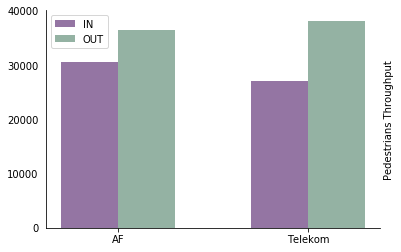

The buildings must be spawning pedestrians from the cellar 😱🧙
Or there might be different Entries to the building...


In [13]:
# as bar chart
bar_width = 0.3
bars1 = [count_walked_IN_af, count_walked_IN_tel]
bars2 = [count_walked_OUT_af, count_walked_OUT_tel]
# x position of bars
r1 = np.arange(len(bars1))
r2 = [x + bar_width for x in r1]
# create bars1
plt.bar(r1, bars1, width=bar_width, color=(0.3,0.1,0.4,0.6), capsize=7, label='IN')
plt.bar(r2, bars2, width=bar_width, color=(0.3,0.5,0.4,0.6), capsize=7, label='OUT')

# general layout
plt.xticks([0.15, 1.15], ['AF', 'Telekom'])
plt.ylabel('Pedestrians Throughput')
plt.gca().yaxis.set_label_position("right")
plt.locator_params(axis='y', nbins=5)
plt.legend()
plt.tick_params(top=False, bottom=True, left=False, right=False, labelleft=True, labelbottom=True)
# Hide the right and top spines
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)

# Show graphic
plt.show()
print('The buildings must be spawning pedestrians from the cellar 😱🧙')
print('Or there might be different Entries to the building...')

In [14]:
# times = pd.to_datetime(df_pedestrians_IN_tel.Timestamp)
# pd.DatetimeIndex(times).hour

times = pd.DatetimeIndex(df_pedestrians_IN_af.Timestamp)
grouped = df_pedestrians_IN_af.groupby([times.hour])
grouped_direction_count = grouped['Direction'].count()

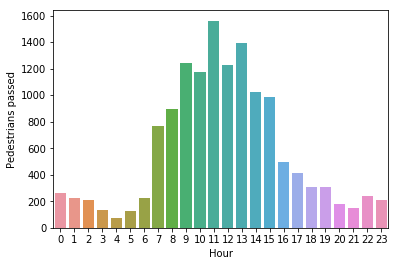

In [15]:
hist_in_out_pedestrians = sns.barplot(x=grouped_direction_count.index, y=grouped_direction_count.values)
hist_in_out_pedestrians.set(xlabel='Hour', ylabel='Pedestrians passed')
sns.distplot
plt.show()

## WIFI Connections

In [18]:
df_wifi_original = pd.read_csv('data/wifi.csv', sep=" ")
df_wifi = df_wifi_original
df_wifi['Timestamp'] = pd.to_datetime(df_wifi['Timestamp'].astype(int), unit='ms')
df_wifi.head(100)
df_wifi_af2 = df_wifi[df_wifi['Location'] == 'Campus-AF-2']
df_wifi_af2.head(1000)

,Location,Timestamp,DevicesTracked,ApproxVerweildauerSek
2,Campus-AF-2,2018-02-14 13:58:00.347,136,42.0
6,Campus-AF-2,2018-02-14 13:59:00.385,134,19.0
10,Campus-AF-2,2018-02-14 14:00:00.472,158,33.0
14,Campus-AF-2,2018-02-14 14:01:00.573,123,38.0
18,Campus-AF-2,2018-02-14 14:02:00.398,126,35.0
22,Campus-AF-2,2018-02-14 14:03:00.592,132,17.0
26,Campus-AF-2,2018-02-14 14:04:00.385,129,31.0
30,Campus-AF-2,2018-02-14 14:05:00.457,159,37.0
34,Campus-AF-2,2018-02-14 14:06:00.432,124,43.0
38,Campus-AF-2,2018-02-14 14:07:00.382,127,56.0
